In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

plt.style.use('ggplot')
import matplotlib.cm as cm
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/ashrae-energy-prediction/test.csv


In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

From the problem statement, We are asked to build a model and predict energy consumption in kWh for various buildings witht the describing features. This a supervised learning and falls under the type Regression problem.

The data is distributed under 3 categories,
    
    1.training data
    2.Building information
    3.Weather information.
 
 Going below, you will be having much more to know about the data.
    

In [3]:
inputData = reduce_mem_usage(pd.read_csv("/kaggle/input/ashrae-energy-prediction/train.csv"))
print(inputData.head())
print("The total number of training set is", len(inputData))
print("columns which has null records",inputData.isna().any())
inputData['timestamp1'] = pd.to_datetime(inputData['timestamp'],format = "%Y-%m-%d %H:%M:%S")
print("the minimum time stamp", inputData['timestamp1'].min())
print("the maximum time stamp", inputData['timestamp1'].max())
inputData.describe()

Mem. usage decreased to 289.19 Mb (53.1% reduction)
   building_id  meter            timestamp  meter_reading
0            0      0  2016-01-01 00:00:00            0.0
1            1      0  2016-01-01 00:00:00            0.0
2            2      0  2016-01-01 00:00:00            0.0
3            3      0  2016-01-01 00:00:00            0.0
4            4      0  2016-01-01 00:00:00            0.0
The total number of training set is 20216100
columns which has null records building_id      False
meter            False
timestamp        False
meter_reading    False
dtype: bool
the minimum time stamp 2016-01-01 00:00:00
the maximum time stamp 2016-12-31 23:00:00


,building_id,meter,meter_reading
count,2.021610e+07,2.021610e+07,2.021610e+07
mean,7.992780e+02,6.624412e-01,1.988706e+03
std,4.269133e+02,9.309921e-01,1.532159e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01
50%,8.950000e+02,0.000000e+00,7.877500e+01
75%,1.179000e+03,1.000000e+00,2.679840e+02
max,1.448000e+03,3.000000e+00,2.190470e+07


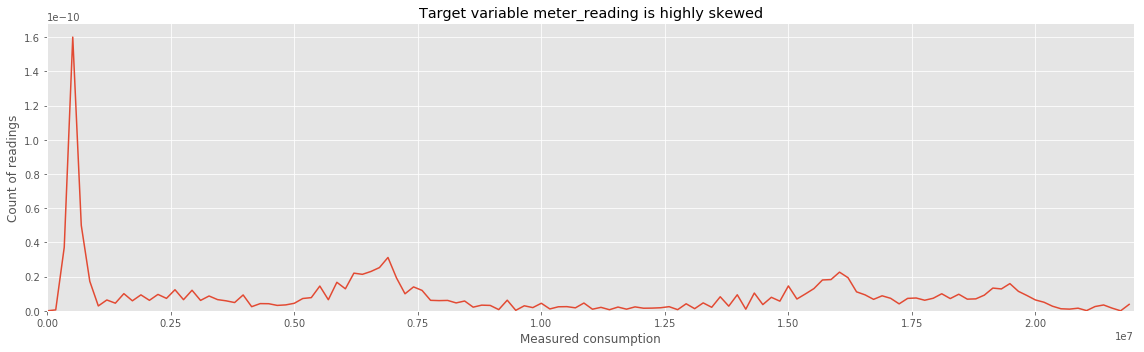

In [4]:
import gc
gc.collect()
plt.figure(figsize=(16,5))
sns.distplot(inputData.meter_reading, hist=False)
plt.title(f"Target variable meter_reading is highly skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, inputData.meter_reading.max() + 100_000)
plt.tight_layout()
plt.show()

From above details, PFB the inferences.
   
       1. Training Data size is almost 20 millions.
       2. No missing values.
       3. The target variable is right skewed.  - How to make this skewed distribution to normal distribution. ?

the skeweness before transformation -0.27537704
the skewness after log transformation 104.81131


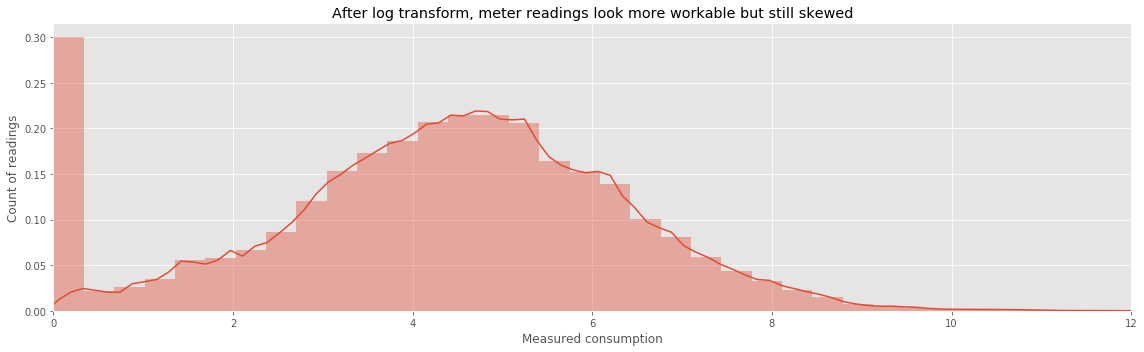

In [5]:
inputData['meter_reading_skewed'] = np.log1p(inputData.meter_reading)

print("the skeweness before transformation",inputData['meter_reading_skewed'].skew())
print("the skewness after log transformation", inputData['meter_reading'].skew())

plt.figure(figsize=(16,5))
sns.distplot(inputData['meter_reading_skewed'])
plt.title(f"After log transform, meter readings look more workable but still skewed")
plt.ylabel("Count of readings")
plt.xlabel(f"Measured consumption")
plt.xlim(0, 12)
plt.tight_layout()
plt.show()

In [6]:
gc.collect()
buildingdf = reduce_mem_usage(pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv"))
print(buildingdf.head())
print("total number of buildings", len(buildingdf))
print("total number of unique sites available", len(np.unique(buildingdf['site_id'])))
print(buildingdf.isna().any())
buildingdf.describe()

Mem. usage decreased to  0.03 Mb (60.3% reduction)
   site_id  building_id primary_use  square_feet  year_built  floor_count
0        0            0   Education         7432      2008.0          NaN
1        0            1   Education         2720      2004.0          NaN
2        0            2   Education         5376      1991.0          NaN
3        0            3   Education        23685      2002.0          NaN
4        0            4   Education       116607      1975.0          NaN
total number of buildings 1449
total number of unique sites available 16
site_id        False
building_id    False
primary_use    False
square_feet    False
year_built      True
floor_count     True
dtype: bool


,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


From the above details, the inferences are,

    1. There are totally 1449 unique buildings
    2. There are totally 16 unique sites.
    3. Year built and floor count tends to have missing values.

In [7]:
gc.collect()
weatherTrainDf = reduce_mem_usage(pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_train.csv"))
print(weatherTrainDf.head())
print("Total records on the weather", len(weatherTrainDf))
print(weatherTrainDf.isna().any())
weatherTrainDf.describe()

Mem. usage decreased to  3.07 Mb (68.1% reduction)
   site_id            timestamp  air_temperature  cloud_coverage  \
0        0  2016-01-01 00:00:00        25.000000             6.0   
1        0  2016-01-01 01:00:00        24.406250             NaN   
2        0  2016-01-01 02:00:00        22.796875             2.0   
3        0  2016-01-01 03:00:00        21.093750             2.0   
4        0  2016-01-01 04:00:00        20.000000             2.0   

   dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
0         20.00000                NaN              1019.5             0.0   
1         21.09375               -1.0              1020.0            70.0   
2         21.09375                0.0              1020.0             0.0   
3         20.59375                0.0              1020.0             0.0   
4         20.00000               -1.0              1020.0           250.0   

   wind_speed  
0    0.000000  
1    1.500000  
2    0.000000  
3    0.000000

,site_id,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,139773.000000,139718.000000,70600.0,139660.000000,89484.0,129155.0,133505.0,139469.000000
mean,7.478977,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.604744,0.000000,0.0,0.000000,NaN,NaN,NaN,0.000000
min,0.000000,-28.906250,0.0,-35.000000,-1.0,968.0,0.0,0.000000
25%,3.000000,7.199219,0.0,0.600098,0.0,1012.0,80.0,2.099609
50%,7.000000,15.000000,2.0,8.296875,0.0,1016.5,190.0,3.099609
75%,11.000000,22.203125,4.0,14.398438,0.0,1021.0,280.0,5.000000
max,15.000000,47.187500,9.0,26.093750,343.0,1046.0,360.0,19.000000


In [8]:
gc.collect()

0

From the above informations,

    1. There are totally 100k records on the weather.
    2. missing values are almost for 7 features out of 9 features.

In [9]:
train_df = pd.merge(inputData,buildingdf,on = 'building_id')
train_df = pd.merge(train_df, weatherTrainDf,on = ['site_id','timestamp'])
train_df.head()

,building_id,meter,timestamp,meter_reading,timestamp1,meter_reading_skewed,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [10]:
train_df = reduce_mem_usage(train_df)
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df["weekday"] = train_df["timestamp"].dt.weekday
train_df["hour"] = train_df["timestamp"].dt.hour

Mem. usage decreased to 1228.37 Mb (3.0% reduction)


In [11]:
train_df.tail()

,building_id,meter,timestamp,meter_reading,timestamp1,meter_reading_skewed,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour
20125600,1400,1,2016-03-24 12:00:00,15.375300,2016-03-24 12:00:00,2.794922,15,Lodging/residential,21168,1928.0,NaN,1.700195,NaN,1.700195,NaN,1017.0,0.0,0.000000,3,12
20125601,1400,1,2016-03-24 13:00:00,25.084801,2016-03-24 13:00:00,3.261719,15,Lodging/residential,21168,1928.0,NaN,2.800781,NaN,2.199219,NaN,1016.5,320.0,1.500000,3,13
20125602,1400,1,2016-03-24 14:00:00,32.343899,2016-03-24 14:00:00,3.507812,15,Lodging/residential,21168,1928.0,NaN,5.601562,NaN,4.398438,NaN,1015.0,110.0,2.099609,3,14
20125603,1400,1,2016-03-24 15:00:00,24.221399,2016-03-24 15:00:00,3.228516,15,Lodging/residential,21168,1928.0,NaN,11.101562,NaN,4.398438,NaN,1014.0,150.0,5.101562,3,15
20125604,1400,1,2016-03-24 16:00:00,16.355301,2016-03-24 16:00:00,2.853516,15,Lodging/residential,21168,1928.0,NaN,15.000000,4.0,4.398438,NaN,1012.0,160.0,8.203125,3,16


In [12]:
import statistics
groupedDf = pd.DataFrame(train_df.groupby(['site_id','building_id','primary_use']).mean()).reset_index().fillna(0)
groupedDf['floor_count'] = groupedDf['floor_count'].apply(lambda x: round(x))
groupedDf.describe()

,site_id,building_id,meter,meter_reading,meter_reading_skewed,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour
count,1449.000000,1449.000000,1449.000000,1.449000e+03,1449.000000,1449.000000,1449.0,1449.000000,1449.000000,1449.000000,1449.000000,1449.000000,1449.0,1449.000000,1449.000000,1449.000000,1449.000000
mean,6.952381,724.000000,0.416726,1.652338e+03,3.927734,92111.776398,inf,0.916494,15.835938,2.083984,8.242188,1.052734,inf,inf,3.552734,3.007049,11.511009
std,5.003432,418.434583,0.548328,5.012091e+04,1.433594,110769.950997,inf,2.303747,5.238281,1.440430,4.484375,1.554688,inf,25.453125,0.754395,0.010684,0.033498
min,0.000000,0.000000,0.000000,4.000000e-04,0.000400,283.000000,0.0,0.000000,4.328125,0.000000,-2.853516,0.000000,0.0,115.062500,2.060547,2.852342,11.111402
25%,3.000000,362.000000,0.000000,3.205503e+01,2.992188,23012.000000,0.0,0.000000,10.867188,0.611816,5.378906,0.248779,1016.0,156.500000,3.076172,3.006266,11.499829
50%,5.000000,724.000000,0.000000,9.414012e+01,3.925781,57673.000000,0.0,0.000000,15.265625,1.958984,8.101562,0.742676,1016.5,185.125000,3.525391,3.007932,11.502905
75%,13.000000,1086.000000,1.000000,2.569249e+02,4.878906,115676.000000,1968.0,0.000000,21.375000,3.064453,9.890625,0.880371,1018.0,188.000000,3.912109,3.009226,11.505940
max,15.000000,1448.000000,2.327849,1.907663e+06,8.562500,875000.000000,2017.0,26.000000,25.250000,5.730469,18.343750,11.429688,1022.5,221.625000,5.515625,3.092885,11.778635


In [13]:
#unique_primaryUse = np.unique(groupedDf['site_id'])
columnsToFill = ['floor_count','air_temperature','year_built','dew_temperature','cloud_coverage','wind_speed']
for cols in columnsToFill:
    print(cols)
    print("-----")
#     for str1 in unique_primaryUse:
#         mask = train_df['site_id']==str1
#         valueToFill = np.unique(groupedDf.loc[groupedDf['site_id']==str1][cols])[0]
#         print(str1,":::",valueToFill)
#         train_df[cols] = np.where(mask, train_df[cols].fillna(valueToFill), train_df[cols])
    if cols=='year_built':
        valueToFill=2017
    else:
        valueToFill = groupedDf[cols].mean()
    print("value to fill",valueToFill)
    train_df[cols] = train_df[cols].fillna(valueToFill)

train_df = reduce_mem_usage(train_df)        
train_df.tail()

floor_count
-----
value to fill 0.9164941338854382
air_temperature
-----
value to fill 15.836
year_built
-----
value to fill 2017
dew_temperature
-----
value to fill 8.24
cloud_coverage
-----
value to fill 2.084
wind_speed
-----
value to fill 3.553
Mem. usage decreased to 1266.76 Mb (17.5% reduction)


,building_id,meter,timestamp,meter_reading,timestamp1,meter_reading_skewed,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour
20125600,1400,1,2016-03-24 12:00:00,15.375300,2016-03-24 12:00:00,2.794922,15,Lodging/residential,21168,1928.0,0.916504,1.700195,2.083984,1.700195,NaN,1017.0,0.0,0.000000,3,12
20125601,1400,1,2016-03-24 13:00:00,25.084801,2016-03-24 13:00:00,3.261719,15,Lodging/residential,21168,1928.0,0.916504,2.800781,2.083984,2.199219,NaN,1016.5,320.0,1.500000,3,13
20125602,1400,1,2016-03-24 14:00:00,32.343899,2016-03-24 14:00:00,3.507812,15,Lodging/residential,21168,1928.0,0.916504,5.601562,2.083984,4.398438,NaN,1015.0,110.0,2.099609,3,14
20125603,1400,1,2016-03-24 15:00:00,24.221399,2016-03-24 15:00:00,3.228516,15,Lodging/residential,21168,1928.0,0.916504,11.101562,2.083984,4.398438,NaN,1014.0,150.0,5.101562,3,15
20125604,1400,1,2016-03-24 16:00:00,16.355301,2016-03-24 16:00:00,2.853516,15,Lodging/residential,21168,1928.0,0.916504,15.000000,4.000000,4.398438,NaN,1012.0,160.0,8.203125,3,16


In [14]:
# train_df['floor_count'] = train_df['floor_count'].fillna(3)
# train_df['air_temperature'] = train_df['air_temperature'].fillna(15.836)
# train_df['year_built'] = train_df['year_built'].fillna(2017)
train_df.isna().any()

building_id             False
meter                   False
timestamp               False
meter_reading           False
timestamp1              False
meter_reading_skewed    False
site_id                 False
primary_use             False
square_feet             False
year_built              False
floor_count             False
air_temperature         False
cloud_coverage          False
dew_temperature         False
precip_depth_1_hr        True
sea_level_pressure       True
wind_direction           True
wind_speed              False
weekday                 False
hour                    False
dtype: bool

In [15]:
testDF = reduce_mem_usage(pd.read_csv("../input/ashrae-energy-prediction/test.csv"))
weather_test = reduce_mem_usage(pd.read_csv("../input/ashrae-energy-prediction/weather_test.csv"))

testDF = pd.merge(testDF, buildingdf, on='building_id')
#testDF = pd.merge(testDF, weather_test, on=['site_id','timestamp'])

Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [16]:
testDF = pd.merge(testDF, weather_test, on=['site_id','timestamp'], how='left')
print(len(testDF))
testDF.isna().any()

41697600


row_id                False
building_id           False
meter                 False
timestamp             False
site_id               False
primary_use           False
square_feet           False
year_built             True
floor_count            True
air_temperature        True
cloud_coverage         True
dew_temperature        True
precip_depth_1_hr      True
sea_level_pressure     True
wind_direction         True
wind_speed             True
dtype: bool

In [17]:
testDF["timestamp"] = pd.to_datetime(testDF["timestamp"])
testDF["weekday"] = testDF["timestamp"].dt.weekday
testDF["hour"] = testDF["timestamp"].dt.hour

In [18]:
testDF.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour
41697595,41692949,1448,0,2018-11-14 10:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,10
41697596,41693199,1448,0,2018-11-14 11:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,11
41697597,41697099,1448,0,2018-05-09 05:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5
41697598,41697349,1448,0,2018-05-09 06:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,6
41697599,41697599,1448,0,2018-05-09 07:00:00,15,Office,92271,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,7


In [19]:
# testDF['floor_count'] = testDF['floor_count'].fillna(3)
# testDF['air_temperature'] = testDF['air_temperature'].fillna(15.836)
# testDF['year_built'] = testDF['year_built'].fillna(2017)
for cols in columnsToFill:
    print(cols)
    print("-----")
#     for str1 in unique_primaryUse:
#         mask = testDF['site_id']==str1
#         valueToFill = np.unique(groupedDf.loc[groupedDf['site_id']==str1][cols])[0]
#         print(str1,":::",valueToFill)
#         testDF[cols] = np.where(mask, testDF[cols].fillna(valueToFill), testDF[cols])
    if cols=='year_built':
        valueToFill=2017
    else:
        valueToFill = groupedDf[cols].mean()
    
    testDF[cols] = testDF[cols].fillna(groupedDf[cols].mean())

testDF =  reduce_mem_usage(testDF)
testDF.tail()

floor_count
-----
air_temperature
-----
year_built
-----
dew_temperature
-----
cloud_coverage
-----
wind_speed
-----
Mem. usage decreased to 2465.49 Mb (11.4% reduction)


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour
41697595,41692949,1448,0,2018-11-14 10:00:00,15,Office,92271,2001.0,0.916504,15.835938,2.083984,8.242188,NaN,NaN,NaN,3.552734,2,10
41697596,41693199,1448,0,2018-11-14 11:00:00,15,Office,92271,2001.0,0.916504,15.835938,2.083984,8.242188,NaN,NaN,NaN,3.552734,2,11
41697597,41697099,1448,0,2018-05-09 05:00:00,15,Office,92271,2001.0,0.916504,15.835938,2.083984,8.242188,NaN,NaN,NaN,3.552734,2,5
41697598,41697349,1448,0,2018-05-09 06:00:00,15,Office,92271,2001.0,0.916504,15.835938,2.083984,8.242188,NaN,NaN,NaN,3.552734,2,6
41697599,41697599,1448,0,2018-05-09 07:00:00,15,Office,92271,2001.0,0.916504,15.835938,2.083984,8.242188,NaN,NaN,NaN,3.552734,2,7


In [20]:
del [[inputData,buildingdf,weatherTrainDf,weather_test]]
gc.collect()

22

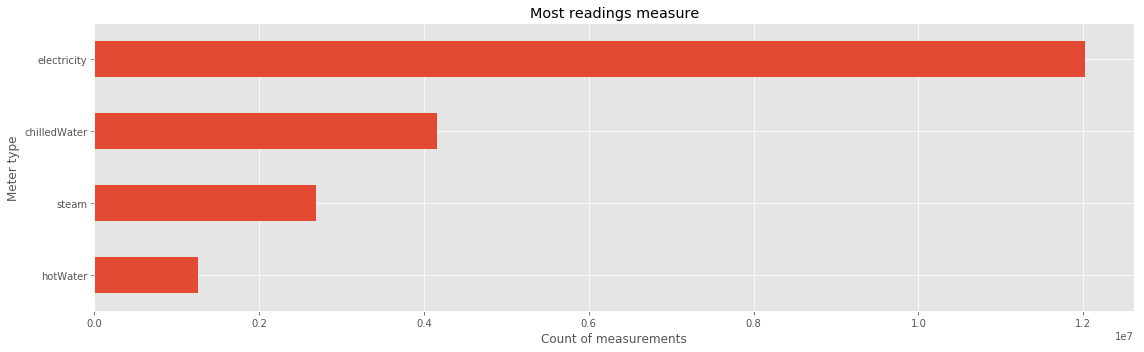

In [21]:
meter_types = ['electricity','chilledWater','steam','hotWater']
plt.figure(figsize=(16,5))
tmp_df = train_df.meter.value_counts()
tmp_df.index = meter_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Most readings measure")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

From the above distribution, it is clear that **Electicity** has more number of readings, then comes **chilledWater** and third occupied by **steam** and **hotwater** has the least number of readings.

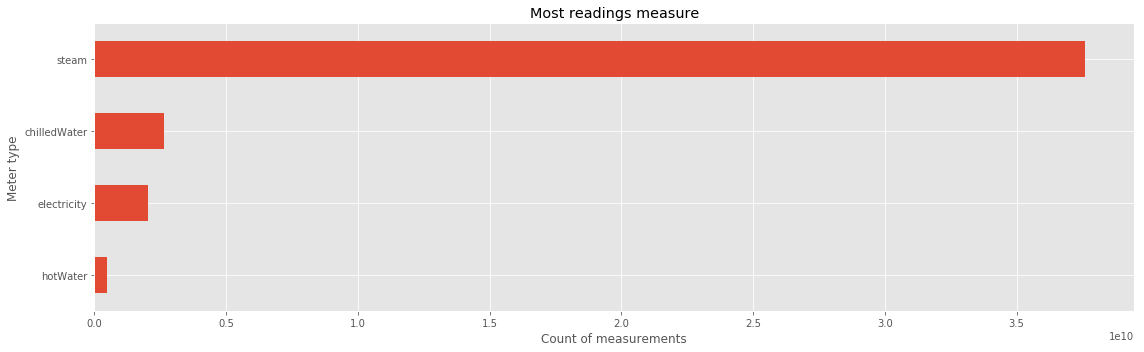

In [22]:
plt.figure(figsize=(16,5))
tmp_df = train_df.groupby('meter').meter_reading.sum()
tmp_df.index = meter_types
tmp_df.sort_values().plot(kind="barh")
plt.title(f"Most readings measure")
plt.xlabel("Count of measurements")
plt.ylabel(f"Meter type")
plt.tight_layout()
plt.show()

From the above distribution, we can observe, for **steam** there is a higher enery consumption and comes **chilledWater** third occupied by **Electricity** and the least consumption is for **hotwater**

In [23]:
train_df = reduce_mem_usage(train_df)
testDF = reduce_mem_usage(testDF)

Mem. usage decreased to 1266.76 Mb (0.0% reduction)
Mem. usage decreased to 2465.49 Mb (0.0% reduction)


In [24]:
train_df['meter_reading_new'] =  train_df['meter_reading']

In [25]:
train_df['meter_reading_skewed'] = np.log1p(train_df['meter_reading_new'])

In [26]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer

import xgboost as xgb
from xgboost import XGBRegressor

from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from mlxtend.regressor import StackingRegressor

In [27]:
train_df = reduce_mem_usage(train_df)
gc.collect()
train_df.head()

Mem. usage decreased to 1343.53 Mb (2.8% reduction)


,building_id,meter,timestamp,meter_reading,timestamp1,meter_reading_skewed,site_id,primary_use,square_feet,year_built,...,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,weekday,hour,meter_reading_new
0,0,0,2016-01-01,0.0,2016-01-01,0.0,0,Education,7432,2008.0,...,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,4,0,0.0
1,1,0,2016-01-01,0.0,2016-01-01,0.0,0,Education,2720,2004.0,...,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,4,0,0.0
2,2,0,2016-01-01,0.0,2016-01-01,0.0,0,Education,5376,1991.0,...,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,4,0,0.0
3,3,0,2016-01-01,0.0,2016-01-01,0.0,0,Education,23685,2002.0,...,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,4,0,0.0
4,4,0,2016-01-01,0.0,2016-01-01,0.0,0,Education,116607,1975.0,...,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,4,0,0.0


In [28]:
#train_df = train_df[:10000]
import category_encoders as ce
testDF = reduce_mem_usage(testDF)
columnsToEncode = ['primary_use','meter','building_id','site_id']

Mem. usage decreased to 2465.49 Mb (0.0% reduction)


In [29]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encodedDF = pd.DataFrame(train_df[columnsToEncode].apply(encoder.fit_transform))
testEncodedDF = pd.DataFrame(testDF[columnsToEncode].apply(encoder.fit_transform))
encodedDF =  reduce_mem_usage(encodedDF)
testEncodedDF =  reduce_mem_usage(testEncodedDF)

# from sklearn.preprocessing import OneHotEncoder
# enc = OneHotEncoder(sparse=False,handle_unknown='ignore')
# enc.fit(train_df[columnsToEncode].apply(encoder.fit_transform))
# trainfinalDF = pd.DataFrame(enc.transform(train_df[columnsToEncode].apply(encoder.fit_transform)))
# testfinalDF = pd.DataFrame(enc.transform(testDF[columnsToEncode].apply(encoder.fit_transform)))

Mem. usage decreased to 249.51 Mb (67.5% reduction)
Mem. usage decreased to 516.96 Mb (67.5% reduction)


In [30]:
# ohe = ce.OneHotEncoder(cols=columnsToEncode, handle_unknown='ignore') 
# encodedDF = ohe.fit_transform(encodedDF)
# encodedDF =  reduce_mem_usage(encodedDF)
# testEncodedDF = ohe.transform(testEncodedDF)
# testEncodedDF =  reduce_mem_usage(testEncodedDF)

In [31]:
gc.collect()

0

In [32]:
columnsToUse = ['square_feet','floor_count','air_temperature','hour','dew_temperature','year_built','weekday'
               ,'cloud_coverage','wind_speed']
encodedDF[columnsToUse] = train_df[columnsToUse]
testEncodedDF[columnsToUse] = testDF[columnsToUse]
encodedDF =  reduce_mem_usage(encodedDF)
testEncodedDF =  reduce_mem_usage(testEncodedDF)

Mem. usage decreased to 594.99 Mb (0.0% reduction)
Mem. usage decreased to 1471.34 Mb (0.0% reduction)


In [33]:
modelxgb = XGBRegressor(colsample_bytree=0.8,
             learning_rate=0.05,
             max_depth=5, n_estimators=500,
             n_jobs=2,objective='reg:squarederror', random_state=42)

from sklearn.model_selection import train_test_split

modellgb = LGBMRegressor(learning_rate=0.05, n_estimators=2028, objective='regression',reg_lambda=2,
                     boosting_type='gbdt', num_leaves=1000, random_state=42)

modelridge = Ridge(alpha=0.3)
modellasso = Lasso(alpha=0.3)

model = StackingRegressor(regressors=(modelxgb, modelridge, modellasso),
        meta_regressor=modelxgb, use_features_in_secondary=True)
ydf = train_df['meter_reading_skewed']

del [[train_df]]
gc.collect()
# # recordToProcess = 15000000
# # train_x = encodedDF[:recordToProcess]
# # train_y = train_df['meter_reading_skewed'][:recordToProcess]
# # eval_x = encodedDF[-recordToProcess:]
# # eval_y = train_df['meter_reading_skewed'][-recordToProcess:]
# ydf = train_df['meter_reading_skewed']
# train_x, eval_x, train_y, eval_y = train_test_split(encodedDF,ydf, test_size=0.24, random_state=22)

# del [[train_df, encodedDF, groupedDf, ydf]]
# gc.collect()
# print("train size", train_x.shape)
# print("validation size", eval_x.shape)

0

In [34]:
from tqdm import tqdm
def predictValues(model, vectors):
    results_dummy=[]
    size=200000
    i=0
    #print(model.predict(np.array(vectors[1:20])))
    for j in tqdm(range(int(np.ceil(vectors.shape[0]/size)))):
        results_dummy.extend(model.predict(np.array(vectors[i:i+size])))
        i+=size
        #print(results_dummy)
    return results_dummy

In [35]:
#model.fit(train_x,train_y, eval_set=[(eval_x,eval_y)],eval_metric='rmse',early_stopping_rounds=5,verbose=5)#
from datetime import datetime
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
kf = KFold(n_splits=5,shuffle=False ,random_state=42)
gc.collect()
models = []
limitToUse = 100000000
# model = StackingRegressor(regressors=(modelxgb, modelridge, modellasso),
#         meta_regressor=modelxgb, use_features_in_secondary=True)
model = modellgb
ydf1=ydf.head(limitToUse)
features = encodedDF.head(limitToUse)
for idx, (train_idx, val_idx) in enumerate(kf.split(features)):
    print(idx)
    print(datetime. now())
    train_features, train_target = encodedDF.iloc[train_idx], ydf1.iloc[train_idx]
    val_features, val_target = encodedDF.iloc[val_idx], ydf1.iloc[val_idx]
    print("training feature shape", train_features.shape)
    print("validation feature sahpe", val_features.shape)
    
    

    model.fit(np.array(train_features), np.array(train_target),eval_set=(np.array(val_features),np.array(val_target)),
             early_stopping_rounds=20, verbose=False)
    models.append(model)
    #print(predictValues(model,val_features))
    print('RMSE: {:.4f} of fold: {}'.format(
        np.sqrt(mean_squared_error(val_target, predictValues(model,val_features))), idx))
    print(datetime. now())
    del train_features, train_target, val_features, val_target; gc.collect()

0
2019-12-19 11:09:54.065399
training feature shape (16100484, 13)
validation feature sahpe (4025121, 13)


100%|██████████| 21/21 [01:01<00:00,  2.94s/it]


RMSE: 1.8649 of fold: 0
2019-12-19 11:17:41.648391
1
2019-12-19 11:17:41.867705
training feature shape (16100484, 13)
validation feature sahpe (4025121, 13)


100%|██████████| 21/21 [00:30<00:00,  1.43s/it]


RMSE: 1.0624 of fold: 1
2019-12-19 11:23:03.591486
2
2019-12-19 11:23:03.791050
training feature shape (16100484, 13)
validation feature sahpe (4025121, 13)


100%|██████████| 21/21 [00:22<00:00,  1.06s/it]


RMSE: 1.8174 of fold: 2
2019-12-19 11:27:25.512261
3
2019-12-19 11:27:25.733250
training feature shape (16100484, 13)
validation feature sahpe (4025121, 13)


100%|██████████| 21/21 [00:31<00:00,  1.51s/it]


RMSE: 2.0007 of fold: 3
2019-12-19 11:32:43.246554
4
2019-12-19 11:32:43.468743
training feature shape (16100484, 13)
validation feature sahpe (4025121, 13)


100%|██████████| 21/21 [00:47<00:00,  2.25s/it]


RMSE: 1.8850 of fold: 4
2019-12-19 11:39:20.181578


In [36]:
results =[]
for model in models:
    if(len(results)==0):
        results= ((np.expm1(predictValues(model, testEncodedDF)))/len(models))
    else:
        results+= ((np.expm1(predictValues(model, testEncodedDF)))/len(models))
    #del model
    gc.collect()

results[1:10]

100%|██████████| 209/209 [07:24<00:00,  2.12s/it]


array([ 7.71212195,  4.23681504, 33.25046105, 29.2098471 , 12.1736409 ,
        5.17719459, 42.48470209,  2.39899976,  0.61890895])

In [37]:
submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
submission = reduce_mem_usage(submission)
results_df = pd.DataFrame({"row_id": submission['row_id'], "meter_reading": np.clip(results, 0, a_max=None)})
results_df.tail()

Mem. usage decreased to 198.83 Mb (68.7% reduction)


,row_id,meter_reading
41697595,41697595,208.219186
41697596,41697596,218.907470
41697597,41697597,108.505817
41697598,41697598,114.000138
41697599,41697599,156.435471


In [38]:
results_df.head()

,row_id,meter_reading
0,0,3.551278
1,1,7.712122
2,2,4.236815
3,3,33.250461
4,4,29.209847


In [39]:
results_df.to_csv("submission.csv", index=False)

In [40]:
# del [[train_x,train_y,eval_x,eval_y,testDF]]
# gc.collect()

In [41]:
# model.best_iteration_

In [42]:
# gc.collect()
# from tqdm import tqdm
# results_dummy=[]
# size=150000
# i=0
# for j in tqdm(range(int(np.ceil(testEncodedDF.shape[0]/size)))):
#     results_dummy.extend(model.predict(testEncodedDF[i:i+size], num_iteration=model.best_iteration_))
#     i+=size
    
# results_dummy[:10]

In [43]:
# results = model.predict(testEncodedDF, ntree_limit=model.best_ntree_limit)
# results[:10]

In [44]:
# results = np.expm1(results_dummy)
# submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
# submission = reduce_mem_usage(submission)
# results_df = pd.DataFrame({"row_id": submission['row_id'], "meter_reading": np.clip(results, 0, a_max=None)})
# results_df.head()

In [45]:
# results_df.tail()

In [46]:
# results_df.to_csv("submission.csv", index=False)

In [47]:
# import lightgbm as lgb
# from sklearn.model_selection import KFold, StratifiedKFold
# #kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
# kf = KFold(n_splits=3, random_state=42)
# gc.collect()

In [48]:
# models=[]
# params = {
#             "objective": "regression",
#     "boosting": "gbdt",
#     "num_leaves": 1280,
#     "learning_rate": 0.05,
#     "feature_fraction": 0.85,
#     "reg_lambda": 2,
#     "metric": "rmse",
#             }

# for train_index, val_index in kf.split(encodedDF):
#     train_X = encodedDF.iloc[train_index]
#     val_X = encodedDF.iloc[val_index]
#     train_y = train_df['meter_reading_skewed'].iloc[train_index]
#     val_y = train_df['meter_reading_skewed'].iloc[val_index]
#     lgb_train = lgb.Dataset(train_X, train_y,categorical_feature=columnsToEncode)
#     lgb_eval = lgb.Dataset(val_X, val_y,categorical_feature=columnsToEncode)
#     gbm = lgb.train(params,
#                 lgb_train,
#                 num_boost_round=1000,
#                 valid_sets=(lgb_train, lgb_eval),
#                 early_stopping_rounds=100,
#                 verbose_eval = 100)
#     models.append(gbm)

In [49]:
# del [[train_X,val_X,train_y,val_y]]
# gc.collect()

In [50]:
# for model in models:
#     lgb.plot_importance(model)
#     plt.show()

In [51]:
# from datetime import datetime

# partialResults=[]
# for model in models:
#     print(datetime.now())
#     partialResults.append(np.expm1(model.predict(testEncodedDF, num_iteration=model.best_iteration))/len(models))
#     print("done partial...")
#     print(datetime.now())
#     del model
#     gc.collect()

In [52]:
# results = []
# for i in range(len(models)):
#     if results ==[]:
#         print(datetime.now())
#         results =  partialResults[i] / len(models)
#     else:
#         results+= partialResults[i] / len(models)
#         print(datetime.now())

In [53]:
# from datetime import datetime

# results = []
# for model in models:
#     print(datetime.now())
#     if  results == []:
#         results = np.expm1(model.predict(testEncodedDF, num_iteration=model.best_iteration)) / len(models)
#     else:
#         results += np.expm1(model.predict(testEncodedDF, num_iteration=model.best_iteration)) / len(models)
#     print("model completed...")  
#     print(datetime.now())
#     del model
#     gc.collect()

In [54]:
# gc.collect()

In [55]:
# submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
# submission = reduce_mem_usage(submission)

In [56]:
# submission = pd.read_csv('/kaggle/input/ashrae-energy-prediction/sample_submission.csv')
# submission = reduce_mem_usage(submission)
# results_df = pd.DataFrame({"row_id": submission['row_id'], "meter_reading": np.clip(results, 0, a_max=None)})

In [57]:
# results_df.to_csv("submission.csv", index=False)

In [58]:
# del [[encodedDF,testEncodedDF,models]]
# gc.collect()

In [59]:
# del train_df,testDF
# gc.collect()